# 04_10_plot_light_curve_asteroids_using_csv


## 필요한 모듈

이 프로젝트를 위해서는 아래의 모듈이 필요하다. 

> numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ccdproc, version_information

### 모듈 설치

1. 콘솔 창에서 모듈을 설치할 때는 아래와 같은 형식으로 입력하면 된다.

>pip install module_name==version

>conda install module_name=version

2. 주피터 노트북(코랩 포함)에 설치 할 때는 아래의 셀을 실행해서 실행되지 않은 모듈을 설치할 수 있다. (pip 기준) 만약 아나콘다 환경을 사용한다면 7행을 콘다 설치 명령어에 맞게 수정하면 된다.

### 모듈 버전 확인

아래 셀을 실행하면 이 노트북을 실행한 파이썬 및 관련 모듈의 버전을 확인할 수 있다.

In [173]:
import importlib, sys, subprocess
packages = "numpy, pandas, matplotlib, scipy, astropy, astroquery, photutils, ysfitsutilpy, ysphotutilpy, ccdproc, aplpy, sncosmo, version_information" # required modules
pkgs = packages.split(", ")
for pkg in pkgs :
    if not importlib.util.find_spec(pkg):
        print(f"**** module {pkg} is being installed")
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])
    else: 
        print(f"**** module {pkg} is installed")

%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information {packages}
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

**** module numpy is installed
**** module pandas is installed
**** module matplotlib is installed
**** module scipy is installed
**** module astropy is installed
**** module astroquery is installed
**** module photutils is installed
**** module ysfitsutilpy is installed
**** module ysphotutilpy is installed
**** module ccdproc is installed
**** module aplpy is installed
**** module sncosmo is installed
**** module version_information is installed
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information
This notebook was generated at 2024-09-17 16:48:01 (KST = GMT+0900) 
0 Python     3.12.3 64bit [GCC 11.2.0]
1 IPython    8.25.0
2 OS         Linux 5.15.0 119 generic x86_64 with glibc2.31
3 numpy      1.26.4
4 pandas     2.2.2
5 matplotlib 3.8.4
6 scipy      1.13.1
7 astropy    6.1.0
8 astroquery 0.4.7
9 photutils  1.12.0
10 ysfitsutilpy 0.2
11 ysphotutilpy 0.1.1
12 ccdproc    2.4.2
13 aplpy      2.1.0
14 sncosmo    2.10.4
15 version_info

### import modules

In [174]:
#%%
from glob import glob
from pathlib import Path
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ccdproc import combine, ccd_process, CCDData

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.wcs import WCS
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astroquery.jplhorizons import Horizons

import astropy.units as u

import ysfitsutilpy as yfu
import ysphotutilpy as ypu

import _astro_utilities
import _Python_utilities
import _tool_visualization

from astropy.nddata import Cutout2D
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clip, sigma_clipped_stats
from photutils.centroids import centroid_com

from photutils.aperture import CircularAperture as CAp
from photutils.aperture import CircularAnnulus as CAn
from photutils.aperture import aperture_photometry as apphot

In [175]:
#%%
#######################################################
BASEDIR = Path("/mnt/Rdata/OBS_data") 
PROJECDIR = Path("/mnt/Rdata/OBS_data/2024-EXO")
TODODIR = PROJECDIR / "_-_-_2024-05_-_GSON300_STF-8300M_-_1bin"
TODODIR = PROJECDIR / "_-_-_2024-06_-_GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "RiLA600_STX-16803_-_2bin"

PROJECDIR = Path("/mnt/Rdata/OBS_data/2022-Asteroid")
TODODIR = PROJECDIR / "GSON300_STF-8300M_-_1bin"
TODODIR = PROJECDIR / "RiLA600_STX-16803_-_1bin"
TODODIR = PROJECDIR / "RiLA600_STX-16803_-_2bin"

# PROJECDIR = Path("/mnt/Rdata/OBS_data/2023-Asteroid")
# TODODIR = PROJECDIR / "GSON300_STF-8300M_-_1bin"
# TODODIR = PROJECDIR / "RiLA600_STX-16803_-_1bin"
# TODODIR = PROJECDIR / "RiLA600_STX-16803_-_2bin"

# PROJECDIR = Path("/mnt/Rdata/OBS_data/2016-Variable")
# TODODIR = PROJECDIR / "-_-_-_2016-_-_RiLA600_STX-16803_-_2bin"

# PROJECDIR = Path("/mnt/Rdata/OBS_data/2017-Variable")
# TODODIR = PROJECDIR / "-_-_-_2017-_-_RiLA600_STX-16803_-_2bin"

DOINGDIRs = sorted(_Python_utilities.getFullnameListOfsubDirs(TODODIR))
print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

BDFDIR = [x for x in DOINGDIRs if "CAL-BDF" in str(x)]
MASTERDIR = Path(BDFDIR[0]) / _astro_utilities.master_dir
if not MASTERDIR.exists():
    os.makedirs("{}".format(str(MASTERDIR)))
    print("{} is created...".format(str(MASTERDIR)))

print ("MASTERDIR: ", format(MASTERDIR))

DOINGDIRs = sorted([x for x in DOINGDIRs if "_LIGHT_" in str(x)])
print ("DOINGDIRs: ", format(DOINGDIRs))
print ("len(DOINGDIRs): ", format(len(DOINGDIRs)))

filter_str = '216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin'
DOINGDIRs = [x for x in DOINGDIRs if filter_str in x]

# remove = 'BIAS'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'DARK'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
# remove = 'FLAT'
# DOINGDIRs = [x for x in DOINGDIRs if remove not in x]
print ("DOINGDIRs: ", DOINGDIRs)
print ("len(DOINGDIRs): ", len(DOINGDIRs))
#######################################################

DOINGDIRs:  ['/mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2022-10-23_-_RiLA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-23_-_RILA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-24_-_RILA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-27_-_RILA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-11-02_-_RILA600_STX-16803_-_2bin/', '/mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-11-04_-_RILA600_STX-16803_-_2bin/']
len(DOINGDIRs):  7
MASTERDIR:  /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/-_CAL-BDF_-_2022-10-23_-_RiLA600_STX-16803_-_2bin/ma

In [176]:
# DOINGDIRs = DOINGDIRs[1:2]
# print("DOINGDIRs:", DOINGDIRs)

In [177]:
#####################################################################
# Observed location
LOCATION = dict(lon=127.005, lat=37.308889, elevation=101)
Suwon = location = EarthLocation(lon=127.005 * u.deg, 
                                 lat=37.308889 * u.deg, 
                                 height=101 * u.m)
observatory_code = "P64"

# Used for any `astropy.SkyCoord` object:
SKYC_KW = dict(unit=u.deg, frame='icrs')

#######################################################
# Initial guess of FWHM in pixel
FWHM_INIT = 6

# Photometry parameters
R_AP = 1.5*FWHM_INIT # Aperture radius
R_IN = 4*FWHM_INIT   # Inner radius of annulus
R_OUT = 6*FWHM_INIT  # Outer radius of annulus

Mag_Low = 11.5
Mag_High = 15

Mag_target = 12.5
Mag_delta = 2
ERR_Max = 0.5

coord_delta = 0.00001
coord_delta = 0.0001
#######################################################

In [178]:
for DOINGDIR in DOINGDIRs[:1] :
    DOINGDIR = Path(DOINGDIR)
    print("DOINGDIR", DOINGDIR)

    READINGDIR = DOINGDIR / _astro_utilities.reduced_dir
    READINGDIR = DOINGDIR / _astro_utilities.reduced_nightsky_dir
    
    DIFFPRESULTDIR = DOINGDIR / f"{READINGDIR.parts[-1]}_DPhot_Mag{Mag_target}"
    LIGHTCUEVEDIR = DOINGDIR / "LightCurve"
    if not LIGHTCUEVEDIR .exists():
        os.makedirs("{}".format(str(LIGHTCUEVEDIR )))
        print("{} is created...".format(str(LIGHTCUEVEDIR )))
    

DOINGDIR /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin


In [179]:
csv_in_dir = sorted(list(DIFFPRESULTDIR.glob('*result_photometry.csv')))
if len(csv_in_dir) == 0 : 
    print("len(csv_in_dir):", len(csv_in_dir))
else : 
    df = pd.DataFrame()
    for fpath in csv_in_dir[:]:
        fpath = Path(fpath)
        print(f"starting... {fpath}")
        df_csv = pd.read_csv(fpath)
        df = pd.concat([df, df_csv], axis=0)
    

starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-10-15-50_240sec_RILA600_STX-16803_-20c_2bin_result_photometry.csv
starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-10-25-33_240sec_RILA600_STX-16803_-20c_2bin_result_photometry.csv
starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-10-35-18_240sec_RILA600_STX-16803_-20c_2bin_result_photometry.csv
starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-10-45-02_240sec_RILA600_STX-16

starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-13-10-53_240sec_RILA600_STX-16803_-20c_2bin_result_photometry.csv
starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-13-20-36_240sec_RILA600_STX-16803_-20c_2bin_result_photometry.csv
starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-13-30-19_240sec_RILA600_STX-16803_-20c_2bin_result_photometry.csv
starting... /mnt/Rdata/OBS_data/2022-Asteroid/RiLA600_STX-16803_-_2bin/216KLEOPATRA_LIGHT_-_2022-10-25_-_RILA600_STX-16803_-_2bin/reduced_nightsky_DPhot_Mag12.5/216KLEOPATRA_LIGHT_B_2022-10-25-13-40-02_240sec_RILA600_STX-16

In [180]:
# df_csv

In [181]:
# print(len(df_csv))
# df_csv
# print(len(df))
# df

In [182]:
df.columns
df
len(df)

18510

In [183]:
df = df.drop(columns=['Unnamed: 0'], axis=0)
# df.drop(['Unnamed: 0', 'id'], axis=0)
# df = df.set_index('id')
df['t_middle_dt'] = pd.to_datetime(df['t_middle'])
df = df.reset_index(drop=True)
df

,id,xcenter,ycenter,aperture_sum,msky,sky_std,nsky,nrej,flux_star,flux_err,...,zeropt_avg,e_zeropt,B_magnitude,RAJ2000,DEJ2000,RAJ2000.1,DEJ2000.1,R_magnitude,V_magnitude,t_middle_dt
0,1,24.195796,5.990454,2.927638e+06,13178.978678,250.442699,1006.0,5.0,-426003.840383,3201.630222,...,-25.140739,0.041462,NaN,339.639345,3.749643,339.639345,3.749643,NaN,NaN,2022-10-25 10:17:50.000
1,2,42.537589,6.657579,3.166603e+06,13046.235798,240.493699,1300.0,3.0,-153259.497247,2947.687576,...,-25.140739,0.041462,NaN,339.639487,3.743315,339.639487,3.743315,NaN,NaN,2022-10-25 10:17:50.000
2,3,64.074335,5.907256,3.045027e+06,13071.342615,208.069387,1273.0,13.0,-281224.852294,2727.587287,...,-25.140739,0.041462,NaN,339.639123,3.735893,339.639123,3.735893,NaN,NaN,2022-10-25 10:17:50.000
3,4,250.291159,5.753588,3.024543e+06,13025.995515,189.605869,1281.0,3.0,-290169.223544,2606.317001,...,-25.140739,0.041462,NaN,339.638165,3.671687,339.638165,3.671687,NaN,NaN,2022-10-25 10:17:50.000
4,5,303.099501,5.349279,2.930493e+06,13050.187978,181.301624,1265.0,7.0,-390375.442864,2540.908211,...,-25.140739,0.041462,NaN,339.637767,3.653483,339.637767,3.653483,NaN,NaN,2022-10-25 10:17:50.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18505,206,528.933929,1970.481336,2.096315e+06,8121.383228,72.664815,2258.0,8.0,29674.844950,1710.895588,...,-24.956191,0.018959,NaN,340.208511,3.551994,340.208511,3.551994,NaN,13.654608,2022-10-25 14:14:23.952
18506,207,1683.002629,1977.667092,2.431775e+06,8121.177495,75.613246,2256.0,7.0,365186.867687,1836.750880,...,-24.956191,0.018959,NaN,340.202666,3.154130,340.202666,3.154130,NaN,10.929291,2022-10-25 14:14:23.952
18507,208,1238.576536,1985.094461,2.072620e+06,8122.402135,70.685353,2251.0,14.0,5720.608657,1698.430102,...,-24.956191,0.018959,NaN,340.208436,3.307272,340.208436,3.307272,NaN,15.441974,2022-10-25 14:14:23.952
18508,209,1383.402378,2033.251144,2.074539e+06,8124.850586,73.711666,1486.0,3.0,7016.267767,1742.744928,...,-24.956191,0.018959,NaN,340.224016,3.257002,340.224016,3.257002,NaN,15.220314,2022-10-25 14:14:23.952


In [184]:
targ_name = DOINGDIR.parts[-1].split("_")[0]
targ_name = targ_name.replace("-"," ")
targ_name = ''.join([i for i in targ_name  if not i.isdigit()])
print("targ_name :", targ_name)

targ_name : KLEOPATRA


In [1]:
check_ttimes = df['t_middle_dt'].drop_duplicates()
check_ttimes = check_ttimes.reset_index(drop=ture)
check_ttimes

NameError: name 'df' is not defined

In [197]:
df_targ = pd.DataFrame()
for idx, row in check_ttimes.iterrows() :
    print(idx, row)
    targ_ttime = Time(row['t_middle_dt'])

    obj = Horizons(id=targ_name, location=LOCATION, epochs=targ_ttime.jd)
    result_table = obj.ephemerides()
    print("result_table : {}".format(result_table ))

    pos_sky = SkyCoord(result_table ["RA"][0], result_table ["DEC"][0], unit='deg')
    print("pos_sky: {}".format(pos_sky))

    if not result_table :
        print("there is no result...")
    else : 
        # print(result_table.columns)
        print("result_table :", result_table)

        # type(result_table['RA'][0])
        # result_table['RA'][0].split(" ")
        # targ_sky = SkyCoord(ra=f"{result_table['RA'][0].split(' ')[0]}h{result_table['RA'][0].split(' ')[1]}m{result_table['RA'][0].split(" ")[2]}s",
        #                dec=f"{result_table['DEC'][0].split(' ')[0]}d{result_table['DEC'][0].split(' ')[1]}m{result_table['DEC'][0].split(" ")[2]}s", frame='icrs')
        targ_sky = pos_sky
        print("targ_sky :", targ_sky)

        df_one = df.loc[(df["RAJ2000"] > targ_sky.ra.value*(1-coord_delta)) \
                        & (df["RAJ2000"] < targ_sky.ra.value*(1+coord_delta)) \
                        & (df["DEJ2000"] > targ_sky.dec.value*(1-coord_delta))\
                        & (df["DEJ2000"] < targ_sky.dec.value*(1+coord_delta))\
                        & (df['t_middle_dt'] == row['t_middle_dt'])]
        print("df_one :", df_one)
        df_targ = pd.concat([df_targ, df_one], axis=0)

    if df_targ.empty :
        print("df_targ is empty")
    else : 
        df_targ.to_csv(f"{LIGHTCUEVEDIR}/{READINGDIR.parts[-2]}_{READINGDIR.parts[-1]}_light_curve_{coord_delta}.csv")
        print(f"{READINGDIR.parts[-2]}_{READINGDIR.parts[-1]}_light_curve_{coord_delta}.csv is created...")

0 index                            0
t_middle_dt    2022-10-25 10:17:50
Name: 0, dtype: object
result_table :        targetname             datetime_str       ...  PABLon  PABLat
          ---                     ---            ...   deg     deg  
----------------------- ------------------------ ... -------- ------
216 Kleopatra (A880 GB) 2022-Oct-25 10:17:50.000 ... 353.1152 9.2041
pos_sky: <SkyCoord (ICRS): (ra, dec) in deg
    (339.95827, 3.49926)>
result_table :        targetname             datetime_str       ...  PABLon  PABLat
          ---                     ---            ...   deg     deg  
----------------------- ------------------------ ... -------- ------
216 Kleopatra (A880 GB) 2022-Oct-25 10:17:50.000 ... 353.1152 9.2041
targ_sky : <SkyCoord (ICRS): (ra, dec) in deg
    (339.95827, 3.49926)>
df_one :         id     xcenter     ycenter  aperture_sum          msky    sky_std  \
2161  2162  734.825976  938.554269  3.481950e+06  12966.037146  90.609678   

        nsky  nre

result_table :        targetname             datetime_str       ...  PABLon  PABLat
          ---                     ---            ...   deg     deg  
----------------------- ------------------------ ... -------- ------
216 Kleopatra (A880 GB) 2022-Oct-25 10:47:02.375 ... 353.1186 9.2018
pos_sky: <SkyCoord (ICRS): (ra, dec) in deg
    (339.95962, 3.49617)>
result_table :        targetname             datetime_str       ...  PABLon  PABLat
          ---                     ---            ...   deg     deg  
----------------------- ------------------------ ... -------- ------
216 Kleopatra (A880 GB) 2022-Oct-25 10:47:02.375 ... 353.1186 9.2018
targ_sky : <SkyCoord (ICRS): (ra, dec) in deg
    (339.95962, 3.49617)>
df_one :       id     xcenter     ycenter  aperture_sum          msky   sky_std  \
3124  64  724.640771  980.858749  3.486272e+06  12253.836196  88.61503   

        nsky  nrej      flux_star     flux_err  ...  zeropt_avg  e_zeropt  \
3124  2251.0  11.0  368050.588387  2193.7

In [198]:
# targ_name = "WASP 24B"
# from astroquery.simbad import Simbad
# result_table = Simbad.query_object(targ_name)
# result_table

In [199]:
# DOINGDIR.parts
# from astroquery.simbad import Simbad
# result_table = Simbad.query_object(targ_name)
# result_table

In [200]:
# from astroquery.vizier import Vizier
# vizier = Vizier()
# result_tabel = vizier.query_object(targ_name)
# result_tabel

In [201]:
# result_table['RA']

In [202]:
# if not result_table :
#     print("there is no result...")
# else : 
#     # print(result_table.columns)
#     print("result_table :", result_table)

#     # type(result_table['RA'][0])
#     # result_table['RA'][0].split(" ")
#     # targ_sky = SkyCoord(ra=f"{result_table['RA'][0].split(' ')[0]}h{result_table['RA'][0].split(' ')[1]}m{result_table['RA'][0].split(" ")[2]}s",
#     #                dec=f"{result_table['DEC'][0].split(' ')[0]}d{result_table['DEC'][0].split(' ')[1]}m{result_table['DEC'][0].split(" ")[2]}s", frame='icrs')
#     targ_sky = pos_sky
#     print("targ_sky :", targ_sky)

#     coord_delta = 0.00001
#     coord_delta = 0.0001

#     df_targ = df.loc[(df["RAJ2000"] > targ_sky.ra.value*(1-coord_delta)) \
#                     & (df["RAJ2000"] < targ_sky.ra.value*(1+coord_delta)) \
#                     & (df["DEJ2000"] > targ_sky.dec.value*(1-coord_delta))\
#                     & (df["DEJ2000"] < targ_sky.dec.value*(1+coord_delta))\
#                     & (df['t_middle_dt'] == df['t_middle_dt'][0]) ]


In [203]:
# targ_sky = SkyCoord(ra=f"{result_table['RA'][0].split(' ')[0]}h{result_table['RA'][0].split(' ')[1]}m{result_table['RA'][0].split(" ")[2]}s",
#                    dec=f"{result_table['DEC'][0].split(' ')[0]}d{result_table['DEC'][0].split(' ')[1]}m{result_table['DEC'][0].split(" ")[2]}s", frame='icrs')
# targ_sky


In [204]:
# df["RAJ2000"][0]
# targ_sky.ra.value

In [205]:
# print(df.columns)

# df['t_middle_dt'] = pd.to_datetime(df['t_middle'])

# coord_delta = 0.00001
# coord_delta = 0.0001

# df_targ = df.loc[(df["RAJ2000"] > targ_sky.ra.value*(1-coord_delta)) \
#                  & (df["RAJ2000"] < targ_sky.ra.value*(1+coord_delta)) \
#                  & (df["DEJ2000"] > targ_sky.dec.value*(1-coord_delta))\
#                  & (df["DEJ2000"] < targ_sky.dec.value*(1+coord_delta))]
# df['t_middle_dt'] = pd.to_datetime(df['t_middle'])


In [206]:
df_targs
df_targs.columns

Index(['id', 'xcenter', 'ycenter', 'aperture_sum', 'msky', 'sky_std', 'nsky',
       'nrej', 'flux_star', 'flux_err', 'mag_ann', 'merr_ann', 'filename',
       't_start', 't_expos', 't_middle', 'filter', 'zeropt_med', 'zeropt_avg',
       'e_zeropt', 'B_magnitude', 'RAJ2000', 'DEJ2000', 'RAJ2000.1',
       'DEJ2000.1', 'R_magnitude', 'V_magnitude', 't_middle_dt'],
      dtype='object')

In [207]:
ttime = Time(df_targ["t_middle_dt"])
ttime

<Time object: scale='utc' format='datetime64' value=['2022-10-25T10:17:50.000000000' '2022-10-25T10:27:33.367000000'
 '2022-10-25T10:37:18.227000000' '2022-10-25T10:47:02.375000000'
 '2022-10-25T10:56:45.532000000' '2022-10-25T11:06:29.631000000'
 '2022-10-25T11:16:13.656000000' '2022-10-25T11:25:56.792000000'
 '2022-10-25T11:35:39.815000000' '2022-10-25T11:45:23.031000000'
 '2022-10-25T11:55:06.073000000' '2022-10-25T12:04:49.154000000'
 '2022-10-25T12:14:32.456000000' '2022-10-25T12:24:15.703000000'
 '2022-10-25T12:33:58.842000000' '2022-10-25T12:43:41.933000000'
 '2022-10-25T12:53:26.023000000' '2022-10-25T13:03:09.222000000'
 '2022-10-25T13:12:53.301000000' '2022-10-25T13:32:19.497000000'
 '2022-10-25T13:42:02.718000000' '2022-10-25T13:51:45.769000000'
 '2022-10-25T14:01:29.267000000' '2022-10-25T14:11:12.664000000'
 '2022-10-25T10:23:42.220000000' '2022-10-25T10:33:26.229000000'
 '2022-10-25T10:43:11.247000000' '2022-10-25T10:52:54.387000000'
 '2022-10-25T11:02:38.482000000' '2022

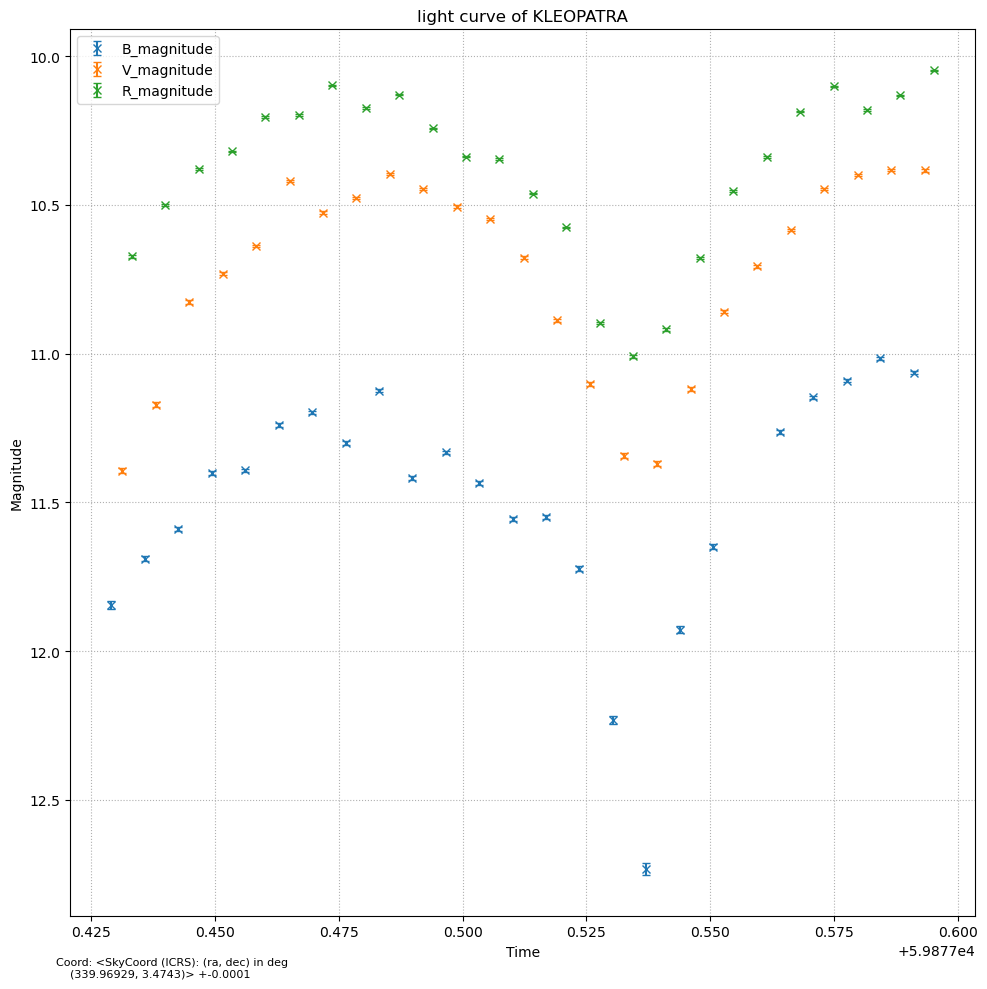

In [208]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), 
                        sharex=False, sharey=False, gridspec_kw=None)

chls = ['B', 'V', 'R']
for chl in chls :

    if f'{chl}_magnitude' in df_targ:
        axs.errorbar(ttime.mjd, 
                df_targ[f'{chl}_magnitude'], yerr=abs(df_targ["merr_ann"]),
                marker='x',
                ls='none',
                #ms=10,
                capsize=3,
                label=f'{chl}_magnitude')

axs.invert_yaxis()
# axs.set_ylim = (df_targ['magnitude'].median()*0.8, df_targ['V_magnitude'].median()*1.2)
axs.set(
    xlabel='Time',
    ylabel="Magnitude",
)
axs.legend()
axs.grid(linestyle=':')

axs.set_title(f"light curve of {targ_name}", fontsize=12,)

axs.annotate(f'Coord: {targ_sky} +-{coord_delta}', fontsize=8,
    xy=(0, 0), xytext=(-10, -30), va='top', ha='left',
    xycoords='axes fraction', textcoords='offset points')

plt.tight_layout()
plt.savefig(f"{LIGHTCUEVEDIR}/{READINGDIR.parts[-2]}_{READINGDIR.parts[-1]}_light_curve_{coord_delta}.png")

plt.show()
# plt.close()

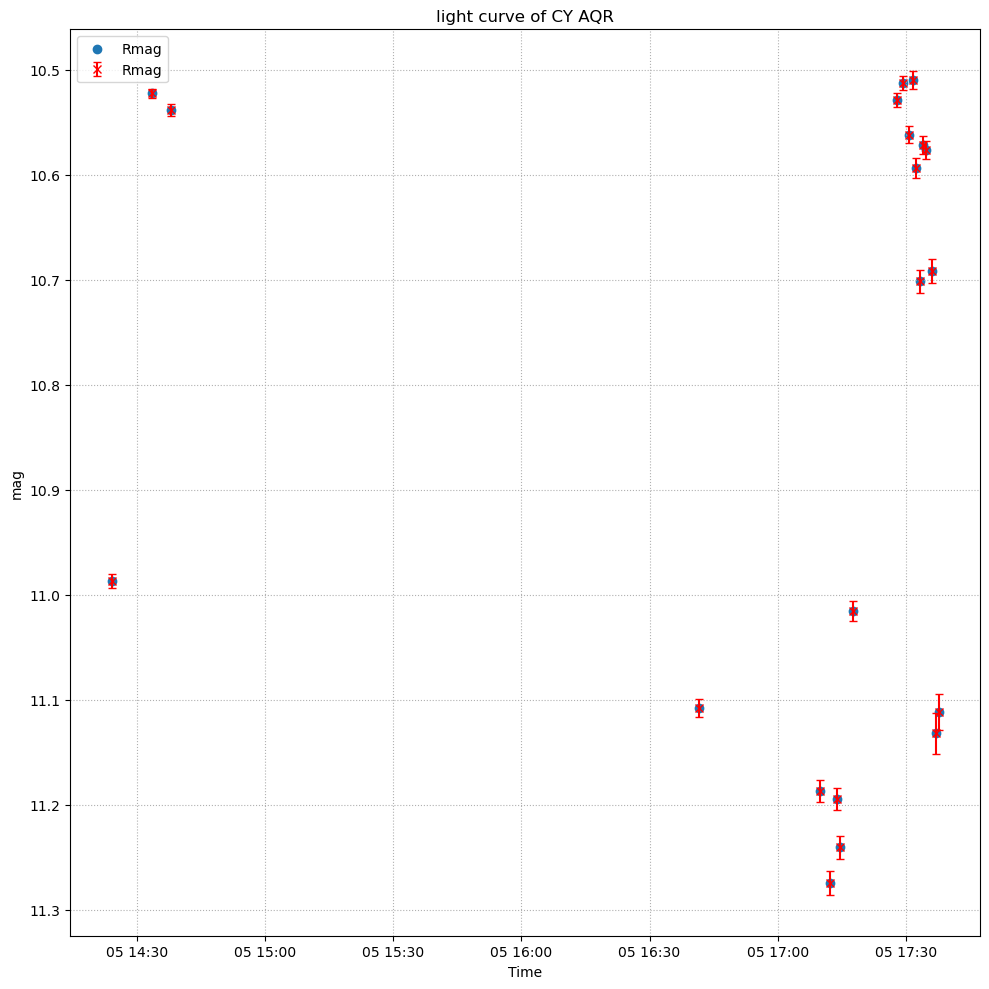

In [182]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), 
                        sharex=False, sharey=False, gridspec_kw=None)

axs.scatter(df_targ["t_middle_dt"], 
            df_targ['V_magnitude'],
            label="Rmag")

axs.errorbar(df_targ["t_middle_dt"], 
            df_targ['V_magnitude'], yerr=abs(df_targ["merr_ann"]),
            marker='x',
            ecolor="red",
            mfc='red',
            mec='red',
            ls='none',
            #ms=10,
            capsize=3,
            label="Rmag")
# axs.errorbar(df_targ["t_middle_dt"], 
#             df_targ['V_magnitude']+1, yerr=abs(df_targ["merr_ann"]),
#             marker='x',
#             # ecolor="yellow",
#             # mfc='yellow',
#             # mec='yellow',
#             ecolor="green",
#             mfc='green',
#             mec='green',
#             ls='none',
#             #ms=10,
#             capsize=3,
#             label="Vmag+1")

axs.invert_yaxis()  
axs.set(
    xlabel='Time',
    ylabel="mag",

)
axs.legend()
axs.grid(linestyle=':')

axs.set_title(f"light curve of {targ_name}", fontsize=12,)

plt.tight_layout()
# plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization1.png")

plt.show()
# plt.close()

KeyError: 'R_magnitude'

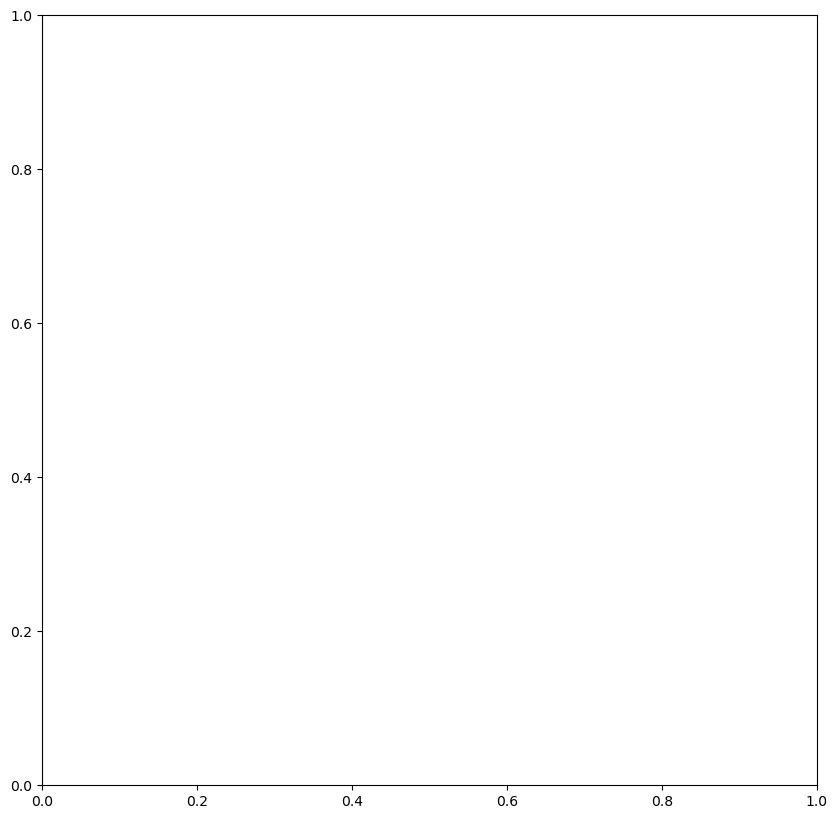

In [126]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10), 
                        sharex=False, sharey=False, gridspec_kw=None)

axs.scatter(df_targ["t_middle_dt"], 
            df_targ['V_magnitude'],
            label="Vmag")

axs.errorbar(df_targ["t_middle_dt"], 
            df_targ['_magnitude'], yerr=abs(df_targ["merr_ann"]),
            marker='x',
            ecolor="red",
            mfc='red',
            mec='red',
            ls='none',
            #ms=10,
            capsize=3,
            label="Vmag")

axs.invert_yaxis()  
axs.set(
    xlabel='Time',
    ylabel="mag",

)
axs.legend()
axs.grid(linestyle=':')

axs.set_title(f"light curve of {targ_name}", fontsize=12,)

plt.tight_layout()
# plt.savefig(f"{DIFFPRESULTDIR}/{fpath.stem}_standardization1.png")

plt.show()
# plt.close()

In [87]:
import lightkurve as lk

In [48]:
search_result = lk.search_lightcurve(targ_name, author="Kepler", cadence="long")
search_result

No data found for target "HAT-P-23b".


SearchResult containing 0 data products.